# Fairness analysis of risk scores

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score


from holisticai.bias.plots import correlation_matrix_plot, abroca_plot
from holisticai.bias.metrics import classification_bias_metrics, abroca
from holisticai.efficacy.metrics import classification_efficacy_metrics

from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio, demographic_parity_difference, demographic_parity_ratio

In [99]:
os.chdir('C:\\Users\\Zezulka\\Documents\\01_PhD\\030-Projects\\2023-01_ALMP_LTU\\')

# file = 'data\\1203_ALMP_effects_risk_fairFemale0001.csv'
# file = 'data\\1203_ALMP_effects_risk_fairFemale_mixed.csv'
# file = "data\\1203_ALMP_effects_risk_fairFemale_001.csv"
file = "data\\1203_ALMP_effects_risk_fairFemale_sim.csv"

df = pd.read_csv(file)

df.head()

,Unnamed: 0,ID,age,canton_french,canton_german,canton_italian,canton_moth_tongue,city,city_big,city_medium,...,sd_policy_Austrian_risk_score_eo_lower_1,sd_policy_Austrian_risk_score_eo_lower_2,sd_policy_Austrian_risk_score_eo_lower_3,sd_policy_Austrian_risk_score_eo_lower_4,sd_policy_Austrian_risk_score_eo_lower_5,sd_policy_Austrian_risk_score_if_lower_1,sd_policy_Austrian_risk_score_if_lower_2,sd_policy_Austrian_risk_score_if_lower_3,sd_policy_Austrian_risk_score_if_lower_4,sd_policy_Austrian_risk_score_if_lower_5
0,1,29410,49,0,1,0,0,3,1,0,...,0.000000,0.025522,0.025522,0.027284,0.027284,0.082857,0.099913,0.056883,0.048936,0.111881
1,2,2306,47,0,1,0,0,1,0,0,...,0.129951,0.112460,0.099804,0.115060,0.111635,0.106649,0.107784,0.104306,0.078342,0.111952
2,3,48710,42,0,1,0,0,1,0,0,...,0.089981,0.118963,0.094978,0.074377,0.090354,0.090889,0.095031,0.119094,0.108857,0.108307
3,4,9665,50,0,1,0,0,1,0,0,...,0.000000,0.034346,0.035054,0.028043,0.034346,0.093497,0.083167,0.060916,0.096911,0.042485
4,5,65086,55,0,1,0,0,1,0,0,...,0.000000,0.000000,0.005230,0.005230,0.004892,0.104249,0.075866,0.100223,0.087461,0.065925


In [100]:
# groups 
female = np.squeeze((df['female'] == 1).values)
male = np.squeeze((df['female'] == 0).values)

non_citizen = np.squeeze((df['swiss'] == 0).values)
citizen = np.squeeze((df['swiss'] == 1).values)

# threshold
t = 0.5

# y_true
y_true = df['y_exit12']
# y_true = 1 - df['y_exit12']

In [101]:
# classification quality
# df_classification_old = classification_efficacy_metrics(y_true, (df['risk_score_logistic'] >= t).astype(int))
df_classification = classification_efficacy_metrics(y_true, (df['risk_score_log'] >= t).astype(int))
df_classification_sp = classification_efficacy_metrics(y_true, (df['risk_score_sp'] >= t).astype(int))
df_classification_eo = classification_efficacy_metrics(y_true, (df['risk_score_eo'] >= t).astype(int))
# df_classification_if = classification_efficacy_metrics(y_true, (df['risk_score_if'] >= t).astype(int))

# df_class_naive = classification_efficacy_metrics(y_test, y_pred_logreg)

classification = pd.concat([df_classification, df_classification_sp, df_classification_eo], axis=1).iloc[:, [0,2,4,1]]
classification.columns = ['Baseline','SP','EO','Reference']

In [102]:
# fairness analysis: group_a = female
'''
df_baseline_old = classification_bias_metrics(female, 
                                              male, 
                                              (df['risk_score_logistic'] >= t).astype(int),
                                              y_true)
'''
df_baseline = classification_bias_metrics(female, 
                                          male, 
                                          (df['risk_score_log'] >= t).astype(int),
                                          y_true)
df_sp = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_sp'] >= t).astype(int),
                                    y_true)
df_eo = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_eo'] >= t).astype(int),
                                    y_true)
'''
df_if = classification_bias_metrics(female, 
                                    male, 
                                    (df['risk_score_if'] >= t).astype(int),
                                    y_true)

df_naive_log = classification_bias_metrics(female_naive, 
                                           male_naive, 
                                           y_pred_logreg,
                                           y_test)
'''
result = pd.concat([df_baseline, df_sp, df_eo], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','SP','EO','Reference']

# Compare results

In [103]:
classification

,Baseline,SP,EO,Reference
Metric,,,,
Accuracy,0.643959,0.643959,0.644519,1
Balanced Accuracy,0.605870,0.608890,0.609357,1
Precision,0.612296,0.605352,0.606604,1
Recall,0.383559,0.404204,0.404129,1
F1-Score,0.471658,0.484739,0.485086,1


In [104]:
result

,Baseline,SP,EO,Reference
Metric,,,,
Statistical Parity,0.116257,0.040623,0.019089,0
Disparate Impact,1.556759,1.156889,1.071307,1
Four Fifths Rule,0.642360,0.864387,0.933439,1
Cohen D,0.267515,0.090901,0.042711,0
2SD Rule,23.581403,8.074918,3.797135,0
Equality of Opportunity Difference,0.172736,0.069538,0.043985,0
False Positive Rate Difference,0.061541,0.005179,-0.013575,0
Average Odds Difference,0.117138,0.037359,0.015205,0
Accuracy Difference,0.019174,0.010068,0.010213,0


In [96]:
accuracy_score(df[df['female']==1]['y_exit12'], (df[df['female']==1]['risk_score_eo'] >= 0.5).astype(int))

0.6479937281733305

In [97]:
accuracy_score(df[df['female']==0]['y_exit12'], (df[df['female']==0]['risk_score_eo'] >= 0.5).astype(int))

0.6420489043439863

In [98]:
1 - df['female'].mean()

0.5635498320268757

In [33]:
df['y_exit12'].mean()

0.4143337066069429

In [34]:
df['risk_score_log'].mean()

0.4126080054016466

In [35]:
df['risk_score_sp'].mean()

0.41296761377223096

In [36]:
df['risk_score_eo'].mean()

0.41297209106730737

In [37]:
df['risk_score_if'].mean()

0.4129626187154695

## Independence Test

In [14]:
# log
p_0 = df['risk_score_log'][female==0].mean()
p_1 = df['risk_score_log'][female==1].mean()

print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))
# print('P(y_hat=0|A=1) - P(y_hat=0|A=0) = ' + str(np.abs((1-p_1) - (1-p_0))))

# sp
p_0 = df['risk_score_sp'][female==0].mean()
p_1 = df['risk_score_sp'][female==1].mean()

print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

# eo
p_0 = df['risk_score_eo'][female==0].mean()
p_1 = df['risk_score_eo'][female==1].mean()

print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

# if
p_0 = df['risk_score_if'][female==0].mean()
p_1 = df['risk_score_if'][female==1].mean()

print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.05022653753115125
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.011916664617669659
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.0011475422901095489
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.002774361556345306


In [48]:
# log
p_0 = (df['risk_score_log'] >= t).astype(int)[female==0].mean()
p_1 = (df['risk_score_log'] >= t).astype(int)[female==1].mean()

print('Log:')
print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str((p_1 - p_0)))
# print('P(y_hat=0|A=1) - P(y_hat=0|A=0) = ' + str(np.abs((1-p_1) - (1-p_0))))

# sp
p_0 = (df['risk_score_sp'] >= t).astype(int)[female==0].mean()
p_1 = (df['risk_score_sp'] >= t).astype(int)[female==1].mean()

print('SP:')
print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

# eo
p_0 = (df['risk_score_eo'] >= t).astype(int)[female==0].mean()
p_1 = (df['risk_score_eo'] >= t).astype(int)[female==1].mean()

print('EO:')
print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

# if
# p_0 = (df['risk_score_if'] >= t).astype(int)[female==0].mean()
# p_1 = (df['risk_score_if'] >= t).astype(int)[female==1].mean()

# print('IF:')
# print('P(y_hat=1|A=1) - P(y_hat=1|A=0) = ' + str(np.abs(p_1 - p_0)))

Log:
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.11852688123731986
SP:
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.023667166907369253
EO:
P(y_hat=1|A=1) - P(y_hat=1|A=0) = 0.01908916255018739


## Separation Test

In [209]:
# log
p_1_tpr = df['risk_score_log'][(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
p_0_tpr = df['risk_score_log'][(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

p_1_fpr = df['risk_score_log'][(df['y_exit12'] == 0) & (df['female'] == 1)].mean()
p_0_fpr = df['risk_score_log'][(df['y_exit12'] == 0) & (df['female'] == 0)].mean()

print('P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = ' + str(np.abs(p_1_tpr - p_0_tpr)))
print('P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = ' + str(np.abs(p_1_fpr - p_0_fpr)))


P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = 0.055552490098754626
P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = 0.036046976621530225


In [105]:
# log
p_1_tpr = (df['risk_score_log'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
p_0_tpr = (df['risk_score_log'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

p_1_fpr = (df['risk_score_log'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 1)].mean()
p_0_fpr = (df['risk_score_log'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 0)].mean()

print('Log:')
print('P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = ' + str(np.abs(p_1_tpr - p_0_tpr)))
print('P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = ' + str(np.abs(p_1_fpr - p_0_fpr)))

# sp
p_1_tpr = (df['risk_score_sp'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
p_0_tpr = (df['risk_score_sp'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

p_1_fpr = (df['risk_score_sp'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 1)].mean()
p_0_fpr = (df['risk_score_sp'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 0)].mean()

print('SP:')
print('P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = ' + str(np.abs(p_1_tpr - p_0_tpr)))
print('P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = ' + str(np.abs(p_1_fpr - p_0_fpr)))

# eo
p_1_tpr = (df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
p_0_tpr = (df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

p_1_fpr = (df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 1)].mean()
p_0_fpr = (df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 0)].mean()

print('EO:')
print('P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = ' + str(np.abs(p_1_tpr - p_0_tpr)))
print('P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = ' + str(np.abs(p_1_fpr - p_0_fpr)))

# if
p_1_tpr = (df['risk_score_if'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
p_0_tpr = (df['risk_score_if'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

p_1_fpr = (df['risk_score_if'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 1)].mean()
p_0_fpr = (df['risk_score_if'] >= t).astype(int)[(df['y_exit12'] == 0) & (df['female'] == 0)].mean()

print('If:')
print('P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = ' + str(np.abs(p_1_tpr - p_0_tpr)))
print('P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = ' + str(np.abs(p_1_fpr - p_0_fpr)))

Log:
P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = 0.17273590437302494
P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = 0.06154068490942541
SP:
P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = 0.06953847406477615
P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = 0.0051793426603745085
EO:
P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = 0.04398486031491289
P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = 0.013575486223437655
If:
P(y_hat=1|A=1,Y=1) - P(y_hat=1|A=0,Y=1) = 0.04842863850465218
P(y_hat=1|A=1,Y=0) - P(y_hat=1|A=0,Y=0) = 0.01101583040126286


In [14]:
(df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 1)].mean()
# (df['risk_score_eo'] >= t).astype(int)[(df['y_exit12'] == 1) & (df['female'] == 0)].mean()

0.42136207741303283

## Sufficiency Test

In [107]:
# log
p_a1y0 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_log'] >= t).astype(int) == 0)].mean()
p_a0y0 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_log'] >= t).astype(int) == 0)].mean()

p_a1y1 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_log'] >= t).astype(int) == 1)].mean()
p_a0y1 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_log'] >= t).astype(int) == 1)].mean()

print('Log:')
print('P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = ' + str(np.abs(p_a1y0 - p_a0y0)))
print('P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = ' + str(np.abs(p_a1y1 - p_a0y1)))

# sp
p_a1y0 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_sp'] >= t).astype(int) == 0)].mean()
p_a0y0 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_sp'] >= t).astype(int) == 0)].mean()

p_a1y1 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_sp'] >= t).astype(int) == 1)].mean()
p_a0y1 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_sp'] >= t).astype(int) == 1)].mean()

print('SP:')
print('P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = ' + str(np.abs(p_a1y0 - p_a0y0)))
print('P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = ' + str(np.abs(p_a1y1 - p_a0y1)))

# eo
p_a1y0 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_eo'] >= t).astype(int) == 0)].mean()
p_a0y0 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_eo'] >= t).astype(int) == 0)].mean()

p_a1y1 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_eo'] >= t).astype(int) == 1)].mean()
p_a0y1 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_eo'] >= t).astype(int) == 1)].mean()

print('EO:')
print('P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = ' + str(np.abs(p_a1y0 - p_a0y0)))
print('P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = ' + str(np.abs(p_a1y1 - p_a0y1)))

# if
p_a1y0 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_if'] >= t).astype(int) == 0)].mean()
p_a0y0 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_if'] >= t).astype(int) == 0)].mean()

p_a1y1 = df['y_exit12'][(df['female'] == 1) & ((df['risk_score_if'] >= t).astype(int) == 1)].mean()
p_a0y1 = df['y_exit12'][(df['female'] == 0) & ((df['risk_score_if'] >= t).astype(int) == 1)].mean()

print('If:')
print('P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = ' + str(np.abs(p_a1y0 - p_a0y0)))
print('P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = ' + str(np.abs(p_a1y1 - p_a0y1)))

Log:
P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = 0.011153121877831185
P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = 0.061569190176363864
SP:
P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = 0.011270600947347553
P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = 0.07249432993750904
EO:
P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = 0.015842253303519682
P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = 0.0814027177143326
If:
P(y=1|A=1,y_hat=0) - P(y=1|A=0,y_hat=0) = 0.0148412082985388
P(y=1|A=1,y_hat=1) - P(y=1|A=0,y_hat=1) = 0.08066751301505892


# Baseline logistic regression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [22]:
# Var list including all dummy categories.
risk_var_list = ["age","canton_moth_tongue","city_big","city_medium","city_no",
                   "emp_share_last_2yrs","emp_spells_5yrs",
                   "female","foreigner_b","foreigner_c","gdp_pc","married","other_mother_tongue","past_income",
                   "prev_job_manager","prev_job_sec_mis","prev_job_sec1","prev_job_sec2",
                   "prev_job_sec3","prev_job_self","prev_job_skilled","prev_job_unskilled",
                   "qual_semiskilled","qual_degree","qual_unskilled","qual_wo_degree",
                   "swiss","ue_spells_last_2yrs","unemp_rate"
                ]

In [23]:
# prepare data
y = df['y_exit12']
X = df[risk_var_list]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

female_naive = np.squeeze((X_test['female'] == 1).values)
male_naive = np.squeeze((X_test['female'] == 0).values)

In [24]:
# Create a logistic regression model
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)
y_score_logreg = y_proba_logreg[:,1]

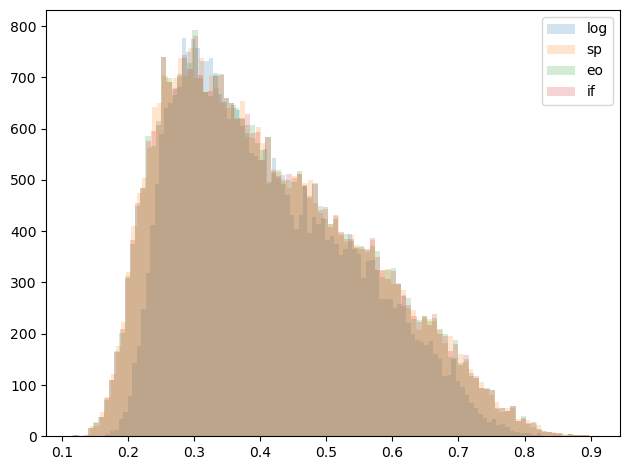

In [25]:
#plt.hist(y_score_logreg, bins=100, alpha=0.5)
plt.hist(df['risk_score_log'], bins=100, alpha=0.2, label='log')
plt.hist(df['risk_score_sp'], bins=100, alpha=0.2, label='sp')
plt.hist(df['risk_score_eo'], bins=100, alpha=0.2, label='eo')
plt.hist(df['risk_score_if'], bins=100, alpha=0.2, label='if')
plt.legend()
plt.tight_layout()
plt.show()